# Minplus algebra experiment

This code attempts to learn the 2D mixture prior
$J(x) = \max_{i \in \{1,...,m\}} \{<p_i^{true},x> - \frac{1}{2}\|p_i^{true}\|^2\}$
assuming we have access to training data $\{y_i, S(y_i)\} = \max_{i \in \{1,...,m\}} \{<p_i^{true},x> - t \theta_i^{true} - \gamma_i^{true}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_4_1_4_2D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

In [2]:

# --- Parameters for Sec 4.1.4---
dim_41 = 2  # Example dimension (e.g., 2D, 4D, 8D as in the paper)
m_41 = 4   # Example number of neurons (e.g., 2 or 4 as in the paper)
data_points_41 = 20000 # Example number of data points
iterations_41 = 1000 # Reduced iterations for demonstration
a_41 = 4 # Grid limit for sampling y_j if using uniform
spacing = 500


# LPN model parameters
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

# === Section 4.1: Cases 4 ===

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    return np.sum(x * x, axis=1)

# --- Case 4 Specific Helper Functions ---
def hjsol_true_case4(y_points, p_true_vectors,t=1):
    """
    Computes the true solution S(y, t=1) for Case 4 from GPL Paper Sec 4.1.
    For Case 4: theta_i = -0.5 * ||p_i||^2 and gamma_i = 0.5 * ||p_i||^2.
    S(y, 1) = max_i { <p_i, y> - (1)*(-0.5 * ||p_i||^2) - (0.5 * ||p_i||^2) }
            = max_i { <p_i, y> }

    Args:
        y_points (np.ndarray): N x dim array of points to evaluate S at.
        p_true_vectors (np.ndarray): m x dim array of the true p_i vectors.
    Returns:
        np.ndarray: N-dimensional array of S(y_j, 1) values.
    """
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    
    s_values = np.zeros((N, m))
    
    # For Case 4, theta_i and gamma_i effectively cancel out in S(y,1)
    theta_true_i = -0.5 * euclid_norm_sq(p_true_vectors) # m-dimensional array
    gamma_true_i = 0.5 * euclid_norm_sq(p_true_vectors)  # m-dimensional array

    for i in range(m):
        # <p_i, y> - 1*theta_i - gamma_i
        s_values[:, i] = inner_prod(y_points, p_true_vectors[i, :]) - t*theta_true_i[i] - gamma_true_i[i]
        # # Simplified due to cancellation:
        # s_values[:, i] = inner_prod(y_points, p_true_vectors[i, :])
        
    return np.max(s_values, axis=1)

def prior_true_case4(y_points, p_true_vectors):
    """
    Computes the true prior J(y) for Case 4 from GPL Paper Sec 4.1.
    For Case 4: gamma_i = 0.5 * ||p_i||^2.
    J(y) = max_i { <p_i, y> - gamma_i }
         = max_i { <p_i, y> - 0.5 * ||p_i||^2 }

    Args:
        y_points (np.ndarray): N x dim array of points to evaluate J at.
        p_true_vectors (np.ndarray): m x dim array of the true p_i vectors.
    Returns:
        np.ndarray: N-dimensional array of J(y_j) values.
    """
    m = p_true_vectors.shape[0]
    N = y_points.shape[0]
    
    j_values = np.zeros((N, m))
    gamma_true_i = 0.5 * euclid_norm_sq(p_true_vectors)  # m-dimensional array

    for i in range(m):
        # <p_i, y> - gamma_i
        j_values[:, i] = inner_prod(y_points, p_true_vectors[i, :]) - gamma_true_i[i]
        
    return np.max(j_values, axis=1)

def cvx_true_case4(y_points, p_true_vectors):
    """
    Computes the target function psi(y) = 0.5*||y||^2 - S(y, t=1) for Case 4.
    This is the function the LPN is trained to approximate.

    Args:
        y_points (np.ndarray): N x dim array of points (y_j).
        p_true_vectors (np.ndarray): m x dim array of the true p_i vectors.
    Returns:
        np.ndarray: N-dimensional array of psi(y_j) values.
    """
    s_y_1 = hjsol_true_case4(y_points, p_true_vectors)
    psi_y = 0.5 * euclid_norm_sq(y_points) - s_y_1
    return psi_y


# --- Functions for evaluating the learned LPN model (adapted from notebook) ---

def invert_prior(x, model, INVERT_MODE):
    """ 
    This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}psi denotes the gradient of the LPN network.
    
    Args:
        x (np.ndarray): A numpy array of real numbers at which to invert the prior.
        model: The trained LPN model object.
        INVERT_MODE: The method for inverting the LPN network.

    Returns:
        np.ndarray: The (approximate) set of points y for which nabla_{y}psi(y) = x.
    """
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_case4(x_eval_points, y_inverted_points, model):
    """ 
    This function evaluates the learned prior J_est(x_eval_points) using the LPN.
    It uses y_inverted_points where x_eval_points = nabla_psi(y_inverted_points).
    The formula used is J_est(x) = <x, y> - 0.5 * ||x||^2 - psi(y)
    
    Args:
        x_eval_points (np.ndarray): N x dim array of points at which to estimate the prior J(x).
        y_inverted_points (np.ndarray): N x dim_psi array of points y such that x_eval_points = nabla_psi(y_inverted_points).
                                       dim_psi is the input dimension to the LPN.
        model: The trained LPN model object (e.g., a torch.nn.Module).

    Returns:
        np.ndarray: N-dimensional array of estimated prior values J_est(x_eval_points).
    """
    # Ensure y_inverted_points is a torch tensor for model input
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: # device might not be defined if torch is not fully set up
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    

    # Formula: J_est(x) = <x,y> - 0.5*||x||^2 - psi(y)
    # Changed to 0.5 * euclid_norm_sq(x) which is 0.5 * ||x||^2.
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est

# --- Plotting tools (Modified) ---

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.
    '''
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    
    x2_0_points = np.copy(grid)
    if dim > 1: # Ensure we don't try to access index 1 if dim is 1
        x2_0_points[:, 1] = xi
    elif dim == 1: # For 1D, x2_0_points is not really a "second axis" cross-section
        x2_0_points = x1_0_points.copy() # Or handle as appropriate for 1D plots

    return xi, x1_0_points, x2_0_points


def cross_sections_plots_case4(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    ''' 
    Compare the true functions for Case 3 vs the LPN model
    on a square grid [-a,a]^{dim} by overlaying their cross sections 
    along the first and (if dim > 1) second axes.

    Args:
        model: The trained LPN model object.
        a: Measure of the grid [-a,a]^{dim}.
        spacing: Number of points in the interval [-a,a].
        p_true_vectors (np.ndarray): m x dim array of true p_i vectors for Case 3.
        INVERT_MODE: The method for inverting the LPN network.
        dim: Spatial dimension of the problem.
    '''
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true psi (cvx_true) and prior (prior_true) for Case 3
    x1_0_psi_true = cvx_true_case4(x1_0_points, p_true_vectors)
    x1_0_J_true = prior_true_case4(x1_0_points, p_true_vectors)

    if dim > 1:
        x2_0_psi_true = cvx_true_case4(x2_0_points, p_true_vectors)
        x2_0_J_true = prior_true_case4(x2_0_points, p_true_vectors)
    else: # For 1D, use the same points for "second" axis plot or omit
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true


    # Compute the learned psi and prior from the LPN model
    x1_0_psi_est = cvx(x1_0_points, model) # LPN directly learns/outputs psi
    y1_inverted = invert_prior(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_case4(x1_0_points, y1_inverted, model)

    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_case4(x2_0_points, y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est


    # Plot cross sections of the convex function psi(y)
    plt.figure() # Use plt.figure() for new plot
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\psi$ (Case 4)") # Changed to dashed for true
    plt.grid(True) # Use boolean for grid
    plt.title(f"Cross sections ($\psi(y_1,0,...)$) - Dim {dim}, Case 4")
    plt.xlabel('$y_1$')
    plt.ylabel('$\psi(y_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\psi$ (Case 4)")
        plt.grid(True)
        plt.title(f"Cross sections ($\psi(0,y_2,0,...)$) - Dim {dim}, Case 4")
        plt.xlabel('$y_2$')
        plt.ylabel('$\psi(0,y_2,0,...)$')
        plt.legend()
        plt.show()

    # Plot cross sections of the prior function J(x)
    # Note: The x-axis here represents the components of x_eval_points,
    # which are the same as y_points for these cross-sections.
    plt.figure()
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J$ (Case 4)")
    plt.grid(True)
    plt.title(f"Cross sections ($J(x_1,0,...)$) - Dim {dim}, Case 4")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()
    plt.show()

    if dim > 1:
        plt.figure()
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J$ (Case 4)")
        plt.grid(True)
        plt.title(f"Cross sections ($J(0,x_2,0,...)$) - Dim {dim}, Case 4")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
        plt.show()


def plot_all_case4(model, a, spacing, p_true_vectors, INVERT_MODE, dim):
    """
    Wrapper to plot cross sections for Case 4.
    """
    print(f"\n--- Plotting Cross Sections for Case 4 (Dim={dim}) ---")
    cross_sections_plots_case4(model, a, spacing, p_true_vectors, INVERT_MODE, dim)

# --- Generate Training Data (using Moreau envelope target as per notebook) ---

In [4]:
print("\n--- Reproducing Section 4.1: Cases 4 ---")

def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0

# --- Generate p_true (randomly in [-1, 1)^n) ---
p_true_41 = np.random.uniform(-1, 1, (m_41, dim_41))
print(f"Generated p_true_41 (shape {p_true_41.shape})")

# --- Generate Training Data (using Moreau envelope target as per notebook) ---
# Sample y_j points (uniformly on [-a, a]^n grid)
y_j_41= np.zeros((dim_41,data_points_41))

if(dim_41>1):
    for k in range(0,dim_41):
        y_j_41[k] = np.random.uniform(-a_41,a_41,data_points_41)
else:
    y_j_41 = np.random.uniform(-a_41,a_41,data_points_41)

#y_j_41 = np.random.uniform(-a_41, a_41, data_points_41)
y_j_41 = y_j_41.reshape(data_points_41,dim_41)

# Calculate S(y_j, t=1) for Case 3
# Calculate target psi(y_j) = 0.5*||y_j||^2 - S(y_j, 1)
cvx_samples_c4 = cvx_true_case4(y_j_41, p_true_41)
cvx_samples_c4 = cvx_samples_c4.reshape(-1, 1) # Reshape for loss calculation
# Recast the samples as tensors
y_j_41 = torch.from_numpy(y_j_41).float()
cvx_samples_c4 = torch.from_numpy(cvx_samples_c4).float()


--- Reproducing Section 4.1: Cases 4 ---
Generated p_true_41 (shape (4, 2))


## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:

# --- Train LPN for Case 4 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c4 = LPN(in_dim=dim_41, hidden=50, layers=5, beta=10,eps=1e-3).to(device)
optimizer_c4 = torch.optim.Adam(lpn_model_c4.parameters(), lr=1e-4)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c4, optimizer_c4, y_j_41,cvx_samples_c4,loss_type=2,gamma_loss=None) # Using MSE

for g in optimizer_c4.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c4, optimizer_c4, y_j_41,cvx_samples_c4,loss_type=2,gamma_loss=None)

# save the model
torch.save(lpn_model_c4.state_dict(), os.path.join(MODEL_DIR, "Case3_l2.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 28.040224075317383
iteration 500 loss 0.8868904113769531
iteration 0 loss 0.4125605523586273
iteration 500 loss 0.3516808748245239
iteration 1000 loss 0.2861904203891754
iteration 1500 loss 0.2148011028766632
iteration 2000 loss 0.14798597991466522
iteration 2500 loss 0.09809882938861847
iteration 3000 loss 0.06757177412509918
iteration 3500 loss 0.0505170114338398
iteration 4000 loss 0.04021366685628891
iteration 4500 loss 0.0327119454741478
iteration 5000 loss 0.02662530168890953
iteration 5500 loss 0.021670673042535782
iteration 6000 loss 0.017757855355739594
iteration 6500 loss 0.014883698895573616
iteration 7000 loss 0.012875726446509361
iteration 7500 loss 0.011502705514431
iteration 8000 loss 0.010518104769289494
iteration 8500 loss 0.009732908569276333
iteration 9000 loss 0.009051326662302017
iteration 9500 loss 0.008389770053327084
iteration 10000 loss 0.007765389978885651
iteration 10500 loss 0.00716670136898756
iteration 11000

L2 loss -- Plot


--- Plotting Cross Sections for Case 4 (Dim=2) ---
loss -105.99588775634766
loss -593.1890869140625
loss -975.25439453125
loss -1279.2469482421875
loss -1491.76708984375
loss -1644.4766845703125
loss -1752.014892578125
loss -1825.24072265625
loss -1872.6380615234375
loss -1901.9677734375
loss -1919.7965087890625
loss -1930.59814453125
loss -1937.023681640625
loss -1940.6390380859375
loss -1942.4835205078125
loss -1943.3077392578125
loss -1943.621337890625
loss -1943.7205810546875
loss -1943.74560546875
loss -1943.750244140625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7510986328125
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7509765625
loss -1943.7510986328125
loss -1943.7510986328125
final mse:  5.3196

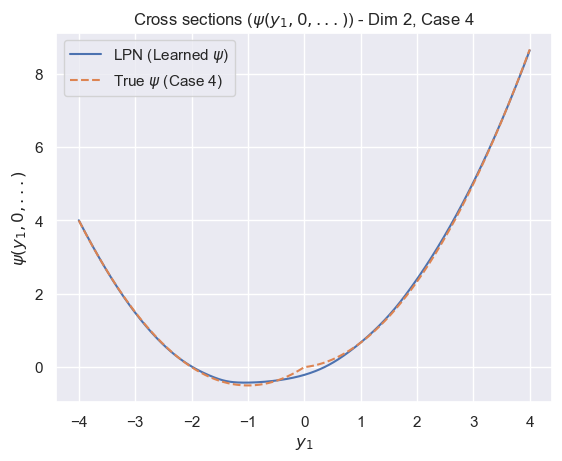

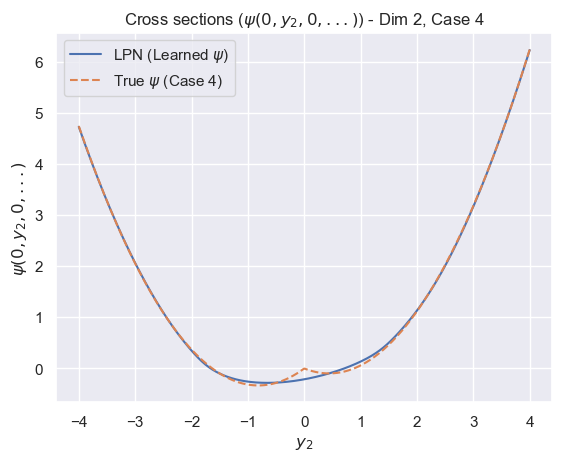

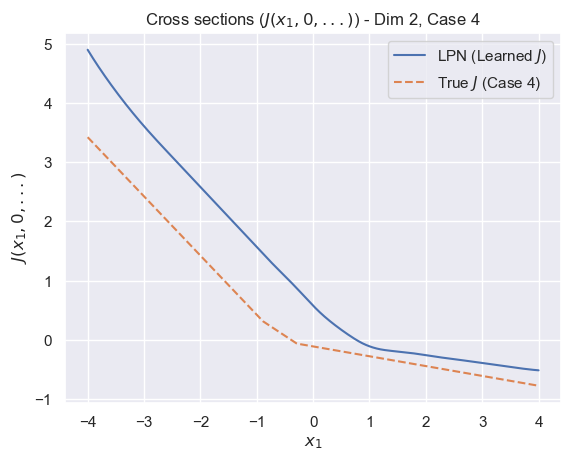

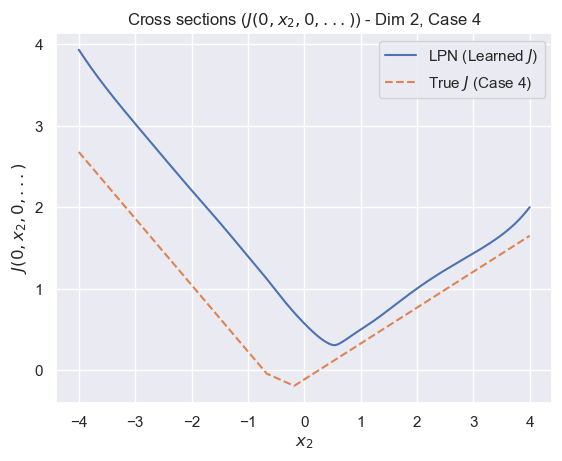

In [7]:
plot_all_case4(lpn_model_c4, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

L1 loss -- Train

In [8]:
# --- Train LPN for Case 4 ---
print("--- Training LPN for Case 3 ---")
lpn_model_c4 = LPN(in_dim=dim_41, hidden=50, layers=5, beta=10,eps=1e-3).to(device)
optimizer_c4 = torch.optim.Adam(lpn_model_c4.parameters(), lr=1e-4)

for i in range(iterations_41):
     single_iteration(i, data_points_41, lpn_model_c4, optimizer_c4, y_j_41,cvx_samples_c4,loss_type=1,gamma_loss=None)

for g in optimizer_c4.param_groups:
    g["lr"] = 1e-4
for i in range(30000):
    single_iteration(i, data_points_41, lpn_model_c4, optimizer_c4, y_j_41,cvx_samples_c4,loss_type=1,gamma_loss=None)

# save the model
torch.save(lpn_model_c4.state_dict(), os.path.join(MODEL_DIR, "Case3_l1.pth"))

--- Training LPN for Case 3 ---
iteration 0 loss 4.214721202850342
iteration 500 loss 0.5768181085586548
iteration 0 loss 0.32538092136383057
iteration 500 loss 0.1986078917980194
iteration 1000 loss 0.1481766551733017
iteration 1500 loss 0.10962807387113571
iteration 2000 loss 0.08861827105283737
iteration 2500 loss 0.07513834536075592
iteration 3000 loss 0.06483685225248337
iteration 3500 loss 0.0572223886847496
iteration 4000 loss 0.05238844081759453
iteration 4500 loss 0.049123700708150864
iteration 5000 loss 0.04675609618425369
iteration 5500 loss 0.04508182778954506
iteration 6000 loss 0.044367481023073196
iteration 6500 loss 0.04315461590886116
iteration 7000 loss 0.04218475893139839
iteration 7500 loss 0.04127366095781326
iteration 8000 loss 0.04070650041103363
iteration 8500 loss 0.03985469415783882
iteration 9000 loss 0.03935211896896362
iteration 9500 loss 0.03908117115497589
iteration 10000 loss 0.038536835461854935
iteration 10500 loss 0.038042858242988586
iteration 11000 

L1 loss -- Plot


--- Plotting Cross Sections for Case 4 (Dim=2) ---
loss -139.0528564453125
loss -611.7313232421875
loss -981.0503540039062
loss -1283.596923828125
loss -1498.860107421875
loss -1649.301025390625
loss -1757.15771484375
loss -1828.953369140625
loss -1874.75
loss -1903.57470703125
loss -1921.3226318359375
loss -1932.017822265625
loss -1938.4217529296875
loss -1942.2528076171875
loss -1944.5223388671875
loss -1945.8443603515625
loss -1946.605712890625
loss -1947.046630859375
loss -1947.308349609375
loss -1947.470947265625
loss -1947.57861328125
loss -1947.656982421875
loss -1947.721435546875
loss -1947.7841796875
loss -1947.858642578125
loss -1947.967041015625
loss -1948.14306640625
loss -1948.4154052734375
loss -1948.7784423828125
loss -1949.2069091796875
loss -1949.69775390625
loss -1950.24462890625
loss -1950.845947265625
loss -1951.5078125
loss -1952.22998046875
loss -1953.055419921875
loss -1953.9144287109375
loss -1954.7781982421875
loss -1955.659912109375
loss -1956.563720703125
fi

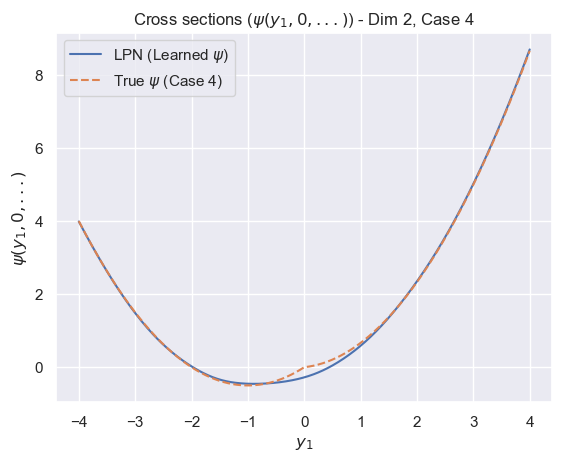

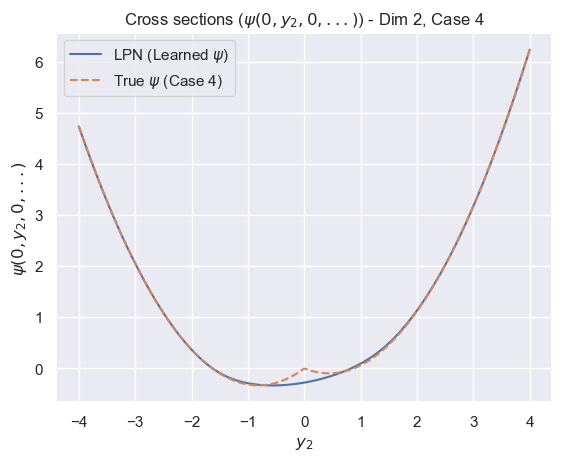

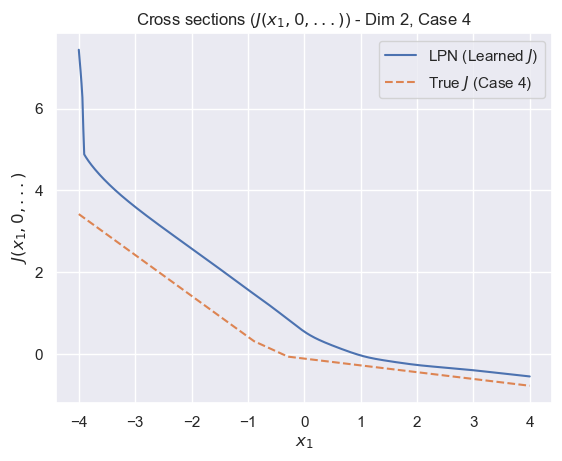

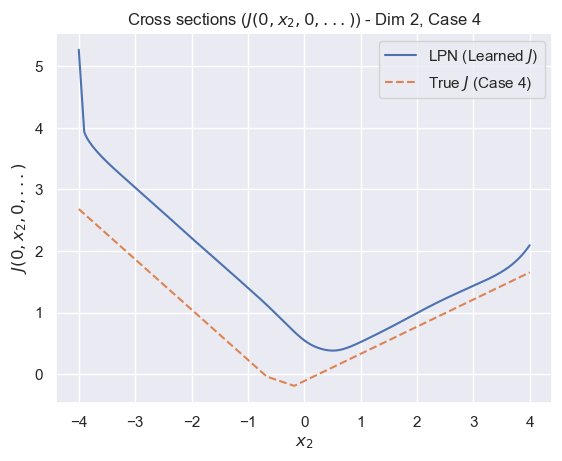

In [9]:
plot_all_case4(lpn_model_c4, a_41, spacing, p_true_41, INVERT_MODE, dim_41)

Proximal matching loss.
We perform proximal matching loss with a decreasing sequence of gamma parameters.

gamma = 20 -- Train

In [10]:
# lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
# optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

# loss_type = 0
# gamma_loss = 20

# # set learning rate
# for g in optimizer.param_groups:
#     g["lr"] = 1e-4

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(3000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 20 -- Plot

In [11]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 12.5 -- Train

In [12]:
# gamma_loss = 12.5

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(6000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 12.5 -- Plot

In [13]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

gamma = 10 -- Train

In [14]:
# gamma_loss = 10

# for g in optimizer.param_groups:
#     g["lr"] = 1e-5

# for i in range(10000):
#     single_iteration(i, data_points, lpn_model, optimizer, loss_type, gamma_loss)

# torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

gamma = 10 -- Plot

In [15]:
# plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)